In [182]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 28
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, jit, prange
import scipy.stats
import itertools
import pyfftw

mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

In [183]:
# @njit
def compute_second_moment(a_k, k0, N):

    dx           = np.pi / N 
    kx           = np.arange(N + 1)
    kx[:k0 + 1]  = 0.0
    a_k_sqr      = (a_k ** 2) * (1.0 / float(N**2))
    sec_mmnt = np.zeros((N))

    for i in range(1, N + 1):
        sec_mmnt[i - 1] = np.sum(a_k_sqr * (1.0 - np.cos( i * dx * kx)))

    return sec_mmnt


In [261]:
def compute_grad(u_z, kmin, kmax):
    print("\nCreating Gradient\n")
    k            = np.concatenate((np.arange(0, kmax + 1), -np.flip(np.arange(1, kmax))))
#     k            = np.concatenate((np.zeros((kmin)), np.arange(kmin, kmax + 1), -np.flip(np.arange(kmin, kmax)), np.zeros((kmin - 1))))
    print(k)
    
    grad_u_z = np.complex(0.0, 0.0) * np.zeros(u_z.shape)
    du_x     = np.zeros(u_z.shape)
    
    for i in range(u_z.shape[0]):
        grad_u_z[i, :] = np.complex(0.0, 1.0) * k * u_z[i, :]
        du_x[i, :]     = np.real(np.fft.ifft(grad_u_z[i, :]))
#     du_x         = np.real(np.fft.ifft(grad_u_z, axis = 1))
    du_x_rms_tmp = np.sqrt(np.mean(du_x[10, :] ** 2))
    du_x_rms     = du_x / du_x_rms_tmp

    return du_x , du_x_rms

In [ ]:
@njit
def compute_velinc(u, rlen):

    # rList  = [int(r) for r in np.arange(1, kmax + 1, kmax/rlen)]
    rList  = [1, kmax]
    du_r   = np.zeros((u.shape[0], u.shape[1], rlen))

    for r_indx, r in enumerate(rList):
        for i in range(u.shape[0]):
            for j in range(u.shape[1]):
                    du_r[i, j, r_indx] = u[i, np.mod(j + r, u.shape[1])] - u[i, j]

    return du_r, rList

In [172]:
def compute_modes_real_space(amps, phases, N):
    print("\n...Creating Real Space Soln...\n")

    # Create full set of amps and phases
    amps_full   = np.append(amps[:], np.flipud(amps[1:-1]))
    phases_full = np.concatenate((phases[:, :], -np.fliplr(phases[:, 1:-1])), axis = 1)

    # Construct modes and realspace soln
    u_z = amps_full * np.exp(np.complex(0.0, 1.0) * phases_full)
    u   = np.real(np.fft.ifft(u_z, axis = 1))

    return u, u_z

@njit
def compute_rms(u):
    
    # Compute normalized realspace soln
    u_urms = np.zeros((u.shape[0], u.shape[1]))
    u_rms  = np.sqrt(np.mean(u[10, :]**2))
    
    for i in range(u.shape[0]):    
        u_urms[i, :] = u[i, :] / u_rms
    
    return u_rms, u_urms

In [ ]:
# @jit(nopython = True)
def compute_vel_inc(u, rlen):

    # rList  = [int(r) for r in np.arange(1, kmax + 1, kmax/rlen)]
    rList  = [1, kmax]
    du_r   = np.zeros((u.shape[0], u.shape[1], rlen))

    for r_indx, r in enumerate(rList):
        for i in range(u.shape[0]):
            for j in range(u.shape[1]):
                    du_r[i, j, r_indx] = u[i, np.mod(j + r, u.shape[1])] - u[i, j]

    return du_r, rList

In [ ]:
# @jit(nopython = True)
def compute_str_p(du_r, rlen):
pList = [2, 3, 4, 5, 6]

str_p     = np.zeros((len(pList), rlen))
str_p_abs = np.zeros((len(pList), rlen))

for r in range(rlen):
    for i, p in enumerate(pList):
        p_du_r          = du_r[:, :, r]**p
        str_p[i, r]     = np.mean(p_du_r.flatten())
        str_p_abs[i, r] = np.absolute(np.mean(p_du_r.flatten()))

return str_p, str_p_abs

In [217]:
#########################
##  Get Input Parameters
#########################
k0    = 1
alpha = 1.0
beta  = 0.0
iters = 1000
trans = 100000
N     = 512
u0    = "RANDOM"

kmin = k0 + 1
kmax = int(N / 2)

filename = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/SolverData_ITERS[{}]_TRANS[{}]".format(N, k0, alpha, beta, u0, iters, trans)


######################
##  Input & Output Dir
######################
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/Stats"


In [218]:
HDFfileData = h5py.File(input_dir + filename + '.h5', 'r')

# print input file name to screen
print("\n\nData File: %s.h5\n" % filename)



Data File: /RESULTS_N[512]_k0[1]_ALPHA[1.000]_BETA[0.000]_u0[RANDOM]/SolverData_ITERS[1000]_TRANS[100000].h5



In [219]:
# Solver data
u_solver      = HDFfileData["RealSpace"][:, :]
u_grad_solver = HDFfileData["RealSpaceGrad"][:, :]
u_z_solver    = HDFfileData["Modes"][:, :]

In [265]:
# Python Data
amps = HDFfileData["Amps"][:]
phi  = HDFfileData["Phases"][:, :]

u, u_z        = compute_modes_real_space(amps, phi, N)
u_rms, u_urms = compute_rms(u)

u_grad, u_grad_rms = compute_grad(u_z, kmin, kmax)

# HDFfileData.close()


...Creating Real Space Soln...


Creating Gradient

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  143  144  145  146  147  148  149  150  151  152  153
  154  155  156  157  158  159  160  161  162  163  164  165  166  167
  168  169  170  171  172  173  174  175  176  177  178  179  180  181
  182  183  184  185  18

In [266]:
t = -1
print(u_z_solver[t, :10])
print(u_z[t, :10])
print(np.allclose(u_z_solver[t, :10], u_z[t, :10]))
u_z.shape

[ 0.        +0.j          0.        +0.j         -0.17571292-0.46810786j
 -0.30630662+0.13148143j -0.15183173-0.19861301j  0.10477696-0.17035782j
  0.09077584+0.13977669j -0.0846466 +0.11507874j  0.12248038-0.02497112j
  0.10420667+0.03855707j]
[ 0.        +0.j          0.        +0.j         -0.17571292-0.46810786j
 -0.30630662+0.13148143j -0.15183173-0.19861301j  0.10477696-0.17035782j
  0.09077584+0.13977669j -0.0846466 +0.11507874j  0.12248038-0.02497112j
  0.10420667+0.03855707j]
True


(1000, 512)

In [267]:
t = -1
print(u_solver[t, :10])
print(u[t, :10])
np.allclose(u_solver[t, :10], u[t, :10])

[-0.00191938 -0.0015275  -0.00085384 -0.00114645 -0.00120578 -0.00138168
 -0.00170702 -0.00100672 -0.00078697 -0.00105843]
[-0.00191938 -0.0015275  -0.00085384 -0.00114645 -0.00120578 -0.00138168
 -0.00170702 -0.00100672 -0.00078697 -0.00105843]


True

[ 0.04705265  0.04594112  0.02709986 -0.04189749  0.01901127 -0.04992744
  0.02378413  0.0579421  -0.01825099 -0.01639221]
[ 0.04705265  0.04594112  0.02709986 -0.04189749  0.01901127 -0.04992744
  0.02378413  0.0579421  -0.01825099 -0.01639221]
True


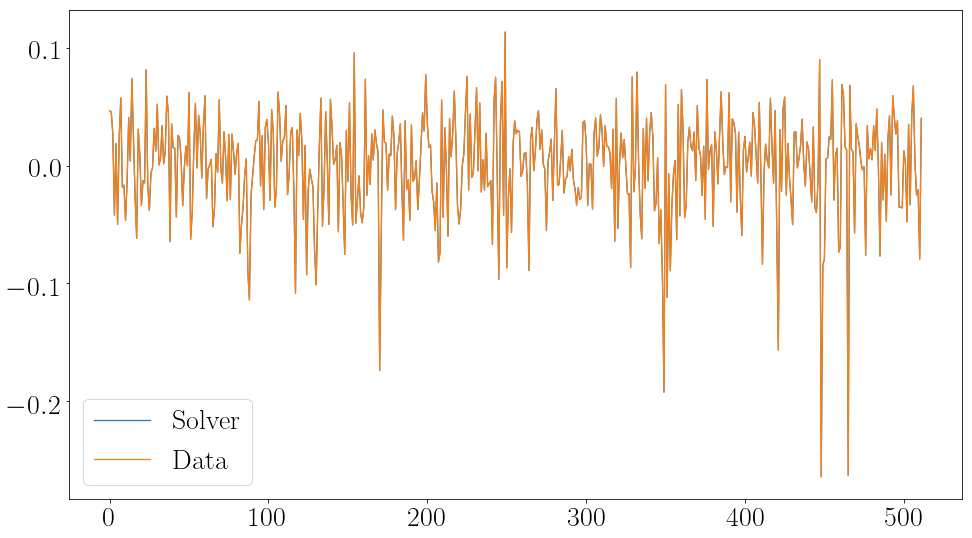

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [270]:
t = -1
print(u_grad_solver[t, :10])
print(u_grad[t, :10])
print(np.allclose(u_grad_solver[t, :10], u_grad[t, :10]))
plt.plot(u_grad_solver[t, :])
plt.plot(u_grad[t, :])
plt.legend(["Solver", "Data"])
plt.show()

print(u_grad[t, :10] / u_grad_solver[t, :10])

In [269]:
print(np.arange(0, kmax + 1))
print(-np.flip(np.arange(1, kmax)))
np.concatenate((np.arange(0, kmax + 1), -np.flip(np.arange(1, kmax))))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [166]:
# Read Velocity Incrments
vel_inc_bincounts = np.zeros((2, 1000))
vel_inc_binedges  = np.zeros((2, 1001))
for i in range(2):
    vel_inc_bincounts[i, :] = HDFfileData["VelInc[{}]_BinCounts".format(i)][:]
    vel_inc_binedges[i, :] = HDFfileData["VelInc[{}]_BinEdges".format(i)][:]
grad_bincounts = HDFfileData["VelGrad_BinCounts"][:]
grad_binedges  = HDFfileData["VelGrad_BinEdges"][:]

vel_inc_stats = HDFfileData["VelIncStats"][:, :]

# Read In Triad Stats
Triad_Cent_R   = HDFfileData["TriadCentroid_R"]
Triad_Cent_Phi = HDFfileData["TriadCentroid_Phi"]

# Read Amps and Structure Functions
amps     = HDFfileData["Amps"][:]
str_func = HDFfileData["StructureFuncs"][:, :]

phi = HDFfileData["Phases"][:, :]

# Close file when done
HDFfileData.close()

In [ ]:
## Plot Histogram of Vel Incrments
plt.figure()
for i in range(2):
    bin_centers = (vel_inc_binedges[i, 1:] + vel_inc_binedges[i, :-1]) * 0.5
    bin_width   = vel_inc_binedges[i, 1] - vel_inc_binedges[i, 0]
    num_obs     = N * iters
    plt.plot(bin_centers, vel_inc_bincounts[i] / (num_obs * bin_width))
# bin_centers = (grad_binedges[1:] + grad_binedges[:-1]) * 0.5
# plt.plot(bin_centers, grad_bincounts)
plt.legend([r"Smallest", r"Largest", r"Gradient"])
plt.yscale('symlog')
plt.grid(True)

plt.show()
# plt.savefig(output_dir + "/PDF_Vel_Incrments_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]_ITERS[{}]_TRANS[{}].png".format(N, k0, alpha, beta, u0, iters, trans), format='png', dpi = 400)  
# plt.close()

In [ ]:
## Plot triad centroid 
fig = plt.figure(figsize = (16, 9), tight_layout = True)
gs  = GridSpec(1, 1)

myjet   = cm.jet(np.arange(255))
norm    = mpl.colors.Normalize(vmin = 0.0, vmax = 1.0)
my_mjet = mpl.colors.LinearSegmentedColormap.from_list('my_map', myjet, N = kmax) # set N to inertial range
my_m.set_under('1.0')
m       = cm.ScalarMappable( norm = norm, cmap = my_mjet)     

ax4  = fig.add_subplot(gs[0, 0])
im   = ax4.imshow(np.transpose(Triad_Cent_R), cmap = my_mjet, norm = norm)
kMax = kmax - kmin # Adjusted indices in triads matrix
kMin = kmin - kmin # Adjusted indices in triads matrix
ax4.set_xticks([kmin, int((kMax - kMin)/5), int(2 * (kMax - kMin)/5), int(3* (kMax - kMin)/5), int(4 * (kMax - kMin)/5), kMax])
ax4.set_xticklabels([kmin, int((kmax - kmin)/5), int(2 * (kmax - kmin)/5), int(3* (kmax - kmin)/5), int(4 * (kmax - kmin)/5), kmax])
ax4.set_yticks([kMin, int((kMax / 2 - kMin)/4), int(2 * (kMax / 2 - kMin)/4), int(3* (kMax / 2 - kMin)/4),  int((kmax)/ 2 - kmin)])
ax4.set_yticklabels([kmin + kmin, int((kmax / 2 - kmin)/4) + kmin, int(2 * (kmax / 2 - kmin)/4) + kmin, int(3* (kmax / 2 - kmin)/4) + kmin,  int(kmax / 2)])
ax4.set_xlabel(r'$k_3$', labelpad = 0)
ax4.set_ylabel(r'$k_1$',  rotation = 0, labelpad = 10)
ax4.set_xlim(left = kmin - 0.5)
ax4.set_ylim(bottom = int((kmax)/ 2 - kmin) + 0.5)
div4  = make_axes_locatable(ax4)
cax4  = div4.append_axes('right', size = '5%', pad = 0.1)
cbar4 = plt.colorbar(im, cax = cax4, orientation='vertical')
cbar4.set_ticks([ 0.0, 0.5, 1])
cbar4.set_ticklabels([r"$0$", r"$0.5$", r"$1$"])

plt.show()
# plt.savefig(output_dir + "/Triad_Centroid_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]_ITERS[{}]_TRANS[{}].png".format(N, k0, alpha, beta, u0, iters, trans), format='png', dpi = 400)  
# plt.close()

In [36]:
amps = np.arange(0.0, n + 1)
amps[1:] = 1/(amps[1:]**(alpha))
n = int(N / 2)
dx           = np.pi / n 
kx           = np.arange(n + 1)
kx[:k0 + 1]  = 0.0
sec_mmnt = np.zeros((n))

for i in range(1, n + 1):
    sec_mmnt[i - 1] = np.sum(amps * (1.0 - np.cos( i * dx * kx)))
    
print(sec_mmnt)

[0.         1.         0.5        0.33333333 0.25       0.2
 0.16666667 0.14285714 0.125      0.11111111 0.1        0.09090909
 0.08333333 0.07692308 0.07142857 0.06666667 0.0625     0.05882353
 0.05555556 0.05263158 0.05       0.04761905 0.04545455 0.04347826
 0.04166667 0.04       0.03846154 0.03703704 0.03571429 0.03448276
 0.03333333 0.03225806 0.03125    0.03030303 0.02941176 0.02857143
 0.02777778 0.02702703 0.02631579 0.02564103 0.025      0.02439024
 0.02380952 0.02325581 0.02272727 0.02222222 0.02173913 0.0212766
 0.02083333 0.02040816 0.02       0.01960784 0.01923077 0.01886792
 0.01851852 0.01818182 0.01785714 0.01754386 0.01724138 0.01694915
 0.01666667 0.01639344 0.01612903 0.01587302 0.015625   0.01538462
 0.01515152 0.01492537 0.01470588 0.01449275 0.01428571 0.01408451
 0.01388889 0.01369863 0.01351351 0.01333333 0.01315789 0.01298701
 0.01282051 0.01265823 0.0125     0.01234568 0.01219512 0.01204819
 0.01190476 0.01176471 0.01162791 0.01149425 0.01136364 0.01123596
 0.

[0.02587115 0.03806794 0.04398132 0.04858031 0.05198557 0.05476167
 0.05715097 0.05909584 0.06092811 0.06239153 0.06386792 0.06501369
 0.06624035 0.06715841 0.06819825 0.06894336 0.06983682 0.07044489
 0.07121958 0.0717155  0.07239116 0.07279294 0.07338424 0.0737054
 0.07422359 0.0744746  0.07492855 0.07511771 0.07551458 0.07564866
 0.07599435 0.07607893 0.07637841 0.07641824 0.07667574 0.07667488
 0.0768941  0.07685611 0.07704029 0.07696831 0.07712035 0.0770172
 0.07713974 0.07700797 0.0771034  0.07694537 0.07701589 0.07683376
 0.07688145 0.07667724 0.07670402 0.07647963 0.07648733 0.07624456
 0.07623491 0.07597547 0.07595012 0.07567564 0.07563617 0.07534821
 0.07529614 0.07499622 0.07493302 0.07462258 0.07454966 0.07423011
 0.07414885 0.07382153 0.07373326 0.0733995  0.0733055  0.07296657
 0.07286809 0.07252523 0.07242348 0.07207789 0.07197404 0.07162688
 0.07152208 0.07117447 0.07106982 0.07072285 0.07061941 0.07027413
 0.07017294 0.06983036 0.0697324  0.06939351 0.06929974 0.068965

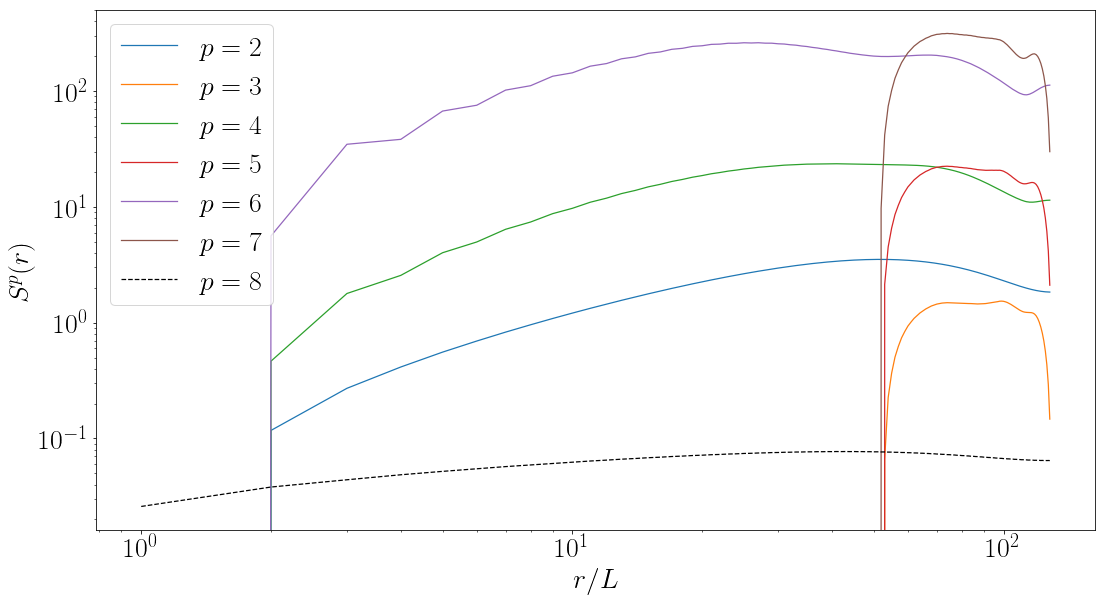

In [62]:
## Plot structure functions
r = np.arange(1, N/2 + 1)

second_moment = compute_second_moment(amps, k0, int(N/2))
print(second_moment)
fig = plt.figure(figsize = (16, 9), tight_layout = True)
gs  = GridSpec(1, 1)
ax  = fig.add_subplot(gs[0, 0])
for i in range(str_func.shape[0]):
    ax.plot(r, str_func[i, :])
ax.plot(r, second_moment[:], 'k--')
ax.legend([r"$p = {}$".format(p) for p in range(2, 8 + 1)])
ax.set_yscale('Log')
ax.set_xscale('Log')
ax.set_xlabel(r"$r / L$")
ax.set_ylabel(r"$S^{p}(r)$")

plt.show()
# plt.savefig(output_dir + "/Structure_Funcs_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]_ITERS[{}]_TRANS[{}].png".format(N, k0, alpha, beta, u0, iters, trans), format='png', dpi = 400)  
# plt.close()

In [42]:
vel_inc_stats

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])